In [4]:
import numpy as np
from scipy import stats
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle

import core
import wocca
import gradient as grad
import visualize as vis
import icons

from ds1_leipzig import *

In [2]:
import importlib
importlib.reload(grad)

<module 'gradient' from '/data/liyichao/code/microstates/wocca_project_code/gradient.py'>

In [2]:
pickle_prefix = "../wocca_project_pickles/ds1_leipzig_"
bounds_fn = pickle_prefix + "bounds.pickle"
wocca_fn = pickle_prefix + "wocca.pickle"
affinity_fn = pickle_prefix + "affinity.pickle"

foundation_fn = pickle_prefix + "foundation.pickle"

ages = np.array([int(st[ : 2]) for st in get_age(subj_ids + subj_ids_ext)])
age_labels = np.array(ages > 50, dtype = int)

### Fresh start

In [ ]:
# %% Load phasemaps and segment boundaries
# NOTICE: MAY TAKE SEVERAL HOURS

v = []
bounds = [0]
ids = []

# Load data
for i in range(n_fn_full):
    tmp = iter_twms(i)
    for j in range(len(tmp)):
        v.append(tmp[j].data.copy())
        bounds.append(bounds[-1] + len(v[-1]))
        ids.append([i // 2, i % 2])

v = np.concatenate(v)
bounds = np.array(bounds)
ids = np.array(ids)
n_data_full, n_v = v.shape
n_segs = len(ids)

# Mark subject and state segments
segs_subjs = np.zeros([n_subj_full + 1], dtype = int)
segs_states = np.zeros([n_subj_full, 3], dtype = int)
k = 0
for i in range(n_subj_full):
    segs_states[i, 0] = k
    for j in range(2):
        while k < n_segs:
            if ids[k, 1] != j:
                break
            k += 1
        segs_states[i, j + 1] = k
    segs_subjs[i + 1] = k

n_data_core = bounds[n_fn_core]

# Save as pickle
with open(bounds_fn, mode = "wb") as FOut:
    pickle.dump((ids, bounds, segs_subjs, segs_states), FOut)

In [ ]:
# %% WOCCA with pre-reduction
# NOTICE: MAY TAKE HOURS WITHOUT GPU, OR SEVERAL MINUTES WITH GPU

n_comps = 10
n_dim_pca = 30

u, pca_basis = wocca.pca_decomp(v[ : n_data_core], n_dim_pca)

# Pre-calculate b matrix using GPU
b = wocca.get_b_matrix(u, wocca.upper_triangle(n_dim_pca), use_torch = True)
del(u)

# WOCCA
ws_pca = wocca.wocca(None, b = b, n_components = n_comps, use_torch = True, backtrack = True)
ws = wocca.pca_recover(ws_pca, pca_basis)

# Total energy and scores
total_energy = wocca.total_energy(v[ : n_data_core])
scores = wocca.score(v[ : n_data_core], ws)

print(total_energy)
for i in range(n_comps):
    print("Score: {:.2f}, Percentage: {:.2f}%".format(scores[i], scores[i] / total_energy * 100))

# Energy by segments
seg_energy = np.array([wocca.total_energy(v[bounds[i] : bounds[i + 1]]) for i in range(n_segs)])

In [ ]:
# %% Manually correct WOCCA component directions and save components

# Invert component directions to (CCw/Cw, FW/BW, RW/LW)
manual_correction = [False, False, False, False]

for i in range(len(manual_correction)):
    if manual_correction[i]:
        ws[i] = np.conj(ws[i])

# Save as pickle
with open(wocca_fn, mode = "wb") as FOut:
    pickle.dump((seg_energy, ws, scores, b), FOut)

In [ ]:
# %% Calculate and save WOCCA component affinities

n_comp_save = 5

pm_basis = []
for i in range(n_comp_save):
    pm_basis += [ws[i], np.conj(ws[i])]
pm_basis = np.array(pm_basis)
affs = core.topomap_affinity(v, pm_basis, False, True)

# Save as pickle
with open(affinity_fn, mode = "wb") as FOut:
    pickle.dump((affs), FOut)

### Load previous results

In [3]:
# %% Reload previous results to skip the time-consuming steps

with open(bounds_fn, mode = "rb") as FIn:
    ids, bounds, segs_subjs, segs_states = pickle.load(FIn)
n_segs = len(ids)

with open(wocca_fn, mode = "rb") as FIn:
    seg_energy, ws, scores, b = pickle.load(FIn)
n_comps, n_v = ws.shape
total_energy = seg_energy.sum()
total_energy_core = seg_energy[ : n_fn_core].sum()

with open(affinity_fn, mode = "rb") as FIn:
    affs = pickle.load(FIn)
n_data_full = len(affs)
n_comp_save = affs.shape[1] // 2
pm_basis = []
for i in range(n_comp_save):
    pm_basis += [ws[i], np.conj(ws[i])]
pm_basis = np.array(pm_basis)

projs = np.zeros([n_data_full, n_comp_save])
for i in range(n_comp_save):
    projs[ : , i] = np.abs(affs[ : , i * 2]) ** 2 - np.abs(affs[ : , i * 2 + 1]) ** 2

In [ ]:
# %% Save foundation data for quick reference

with open(foundation_fn, mode = "wb") as FOut:
    pickle.dump((info.copy(), ws, scores, total_energy_core, "Version 230818.01"), FOut)

### Analysis

In [4]:
# %% Statistics

n_states = 2

def average_per_subject(v):
    if len(v.shape) == 1:
        res = np.zeros([n_subj_full, n_states], dtype = v.dtype)
    else:
        res = np.zeros([n_subj_full, n_states, v.shape[1]], dtype = v.dtype)
    
    for i in range(n_subj_full):
        for j in range(n_states):
            k = i * n_states + j
            res[i, j] = v[bounds[k] : bounds[k + 1]].mean(axis = 0)

    return res

In [5]:
# %% Visualization functions

fig_path = "../wocca_project_figs/explore_leipzig/"
fig_supp_path = "../wocca_project_figs/supplementary/"
comp_labels = ["Rot.", "Long.", "Horiz.", "Lat.", "Comp.5"]
comp_names = ["rot", "fw", "rw", "fs", "c5"]
state_labels = ["EC", "EO"]
state_names_full = ["Eyes closed", "Eyes open"]

default_color = "#607280"
state_colors = ["#114F99", "#49ADFF"]
compare_colors = [["#114F99", "#49ADFF"], ["#1F8C54", "#10D99C"]]
scree_bar_wocca_color = "#4A86C8"
scree_accumulated_color = "#800E20"

pv_thres = [0.001, 0.01, 0.05]
pv_symbols = ["***", "**", "*", "n.s."]
vis.set_pv_string(pv_thres, pv_symbols)

# Draw corresponding icon
def draw_icon(k):
    plt.axis([-0.5, 0.5, -0.5, 0.5])
    if k == 0:
        icons.rotation(default_color, default_color, scale = 1 / 2.54)
    elif k == 1:
        icons.longitudinal(default_color, scale = 1 / 2.54)
    elif k == 2:
        icons.horizontal(default_color, scale = 1 / 2.54)
    else:
        icons.lateral(default_color, scale = 1 / 2.54)

# Compare EC/EO for energy
def draw_eceo_energy_bars(k, **kwargs):
    bar_means = np.array([[energy[..., i, k].mean() for i in range(2)]])
    args = dict(bar_colors = compare_colors[0], scatter_colors = compare_colors[0], line_color = default_color, \
                bar_width = 3, s_size = 1, alpha_s = 0.2, alpha_l = 0.075, dpi = 100, \
                column_lims = np.array([[[0.15, 0.45], [0.8, 1.1]]]), show_xaxis = False, show_yaxis = False, \
                xps = [0.7, 0.25, None, None, None, 0.1], yps = [0.1, 2, 0.2, 0.1], bar_data = bar_means, title = comp_labels[k])
    args.update(kwargs)
    
    tmp = np.array([energy[ : , i, k].reshape([-1, 1]) for i in range(2)])
    fig, ax, column_lims = vis.multi_compare(tmp, **args)
    
    yrng = tmp.min(), tmp.max()
    y_scale = yrng[1] - yrng[0]
    ymin = max(0, yrng[0] - y_scale * 0.05)
    plt.axis(ymin = ymin, ymax = ymin + y_scale * 1.25)
    plt.axhline(y = ymin, lw = 1, c = "#000000", clip_on = False)
    plt.axvline(x = 0, ymax = 1.1 / 1.25, lw = 1, c = "#000000", clip_on = False)

    if eceo_test_energy[k, 1] <= 0.05:
        plt.plot(column_lims[0].mean(axis = -1), [ymin + y_scale * 1.1] * 2, lw = 0.5, c = "#000000")
        plt.text(column_lims.mean(), ymin + y_scale * 1.12, vis.generate_pv_string(eceo_test_energy[k, 1], show_ns = True)[1], \
                 size = "medium", ha = "center", va = "bottom")

    fx, fy = fig.get_size_inches()
    ax2 = plt.axes([0.3 / fx, 1 - 0.45 / fy, (1 / 2.54) / fx, (1 / 2.54) / fy])
    vis.no_axes(ax2)
    draw_icon(k)
    
    return fig, ax, column_lims

# Compare EC/EO for asymmetry
def draw_eceo_asym_bars(k, **kwargs):
    bar_means = np.array([[asym[..., i, k].mean() for i in range(2)]])
    args = dict(bar_colors = compare_colors[1], scatter_colors = compare_colors[1], line_color = default_color, \
                bar_width = 3, s_size = 1, alpha_s = 0.2, alpha_l = 0.075, dpi = 100, \
                column_lims = np.array([[[0.15, 0.45], [0.8, 1.1]]]), show_xaxis = False, show_yaxis = False, \
                xps = [0.7, 0.25, None, None, None, 0.1], yps = [0.1, 2, 0.2, 0.1], bar_data = bar_means, title = comp_labels[k])
    args.update(kwargs)
    
    tmp = np.array([asym[ : , i, k].reshape([-1, 1]) for i in range(2)])
    fig, ax, column_lims = vis.multi_compare(tmp, **args)
    plt.axhline(y = 0, lw = 0.5, c = "#000000", zorder = -15)
    
    yrng = min(0, tmp.min()), max(0, tmp.max())
    y_scale = yrng[1] - yrng[0]
    axh = plt.axis(ymin = yrng[0] - y_scale * 0.05, ymax = yrng[1] + y_scale * 0.2)
    plt.axvline(x = 0, ymax = 1.1 / 1.25, lw = 1, c = "#000000", clip_on = False)
    
    if eceo_test_asym[k, 1] <= 0.05:
        plt.plot(column_lims[0].mean(axis = -1), [yrng[1] + y_scale * 0.05] * 2, lw = 0.5, c = "#000000")
        plt.text(column_lims.mean(), yrng[1] + y_scale * 0.07, vis.generate_pv_string(eceo_test_asym[k, 1], show_ns = True)[1], \
                 size = "medium", ha = "center", va = "bottom")
    for i in range(2):
        if zero_test_asym[i, k, 1] <= 0.05:
            pos_flag = int(zero_test_asym[i, k, 0] > 0)
            neg_flag = 1 - pos_flag
            sign_flag = pos_flag * 2 - 1
            plt.plot([column_lims[0, i, 1] + 0.15] * 2, [bar_means[0, i] - (0.03 - 0.01 * neg_flag) * y_scale, bar_means[0, i] + (0.03 - 0.01 * pos_flag) * y_scale], \
                     lw = 1.5, c = compare_colors[1][i])
            icons.draw_arrow_head([column_lims[0, i, 1] + 0.15, bar_means[0, i] + sign_flag * 0.02 * y_scale], [0, sign_flag * 0.075 * y_scale], \
                                  compare_colors[1][i], 0.075, 0)
            plt.text(column_lims[0, i, 1] + 0.15, bar_means[0, i] + (sign_flag * 0.14 - 0.005) * y_scale, \
                     vis.generate_pv_string(zero_test_asym[i, k, 1], show_ns = False)[1], \
                     size = "medium", ha = "center", va = "center", color = compare_colors[1][i], zorder = 10)

    fx, fy = fig.get_size_inches()
    ax2 = plt.axes([0.3 / fx, 1 - 0.45 / fy, (1 / 2.54) / fx, (1 / 2.54) / fy])
    plt.axis([-0.5, 0.5, -0.5, 0.5])
    vis.no_axes(ax2)
    if k == 0:
        icons.rotation_ccw(default_color, default_color, scale = 1 / 2.54)
    elif k == 1:
        icons.longitudinal_fw(default_color, scale = 1 / 2.54)
    elif k == 2:
        icons.horizontal_rw(default_color, scale = 1 / 2.54)
    else:
        icons.lateral_fs(default_color, scale = 1 / 2.54)
    
    return fig, ax, column_lims

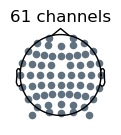

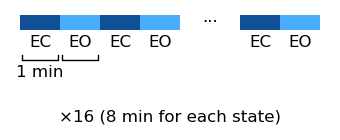

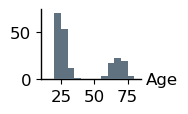

In [14]:
# %% Draw dataset structure diagram

# Channel layout
fx, fy = 1, 1.2
fig = plt.figure(figsize = [fx, fy])
ax = plt.axes([0, 0, 1 / fx, 1 / fy])
vis.disp_topomap(info, np.zeros([n_v]), cmap = vis.whites_cmap, colorbar = False, sensors = False)
tmp_pos = vis.get_phys_pos(info)
plt.scatter(tmp_pos[ : , 0], tmp_pos[ : , 1], s = 20, marker = "o", color = default_color)
fig.text(0.5 / fx, 1 / fy, "{:} channels".format(n_v), ha = "center", va = "bottom", size = "large")

fig.savefig(fig_path + "leipzig_channel_layout.svg", format = "svg")

# Dataset structure
fx, fy = 3.2, 1.2
fig = plt.figure(figsize = [fx, fy])
ax = plt.axes([0, 0, 1, 1])
plt.axis([0, 3.2, 0, 1.2])
vis.no_axes(ax)
for pos, state in [[0.1, 0], [0.5, 1], [0.9, 0], [1.3, 1], [2.3, 0], [2.7, 1]]:
    rect = mpl.patches.Rectangle([pos, 1], 0.4, 0.15, lw = 0, ec = "#00000000", fc = state_colors[state], zorder = 15, clip_on = False)
    ax.add_patch(rect)
    plt.text(pos + 0.2, 0.8, state_labels[state], ha = "center", va = "bottom", size = "large")
plt.plot([0.12, 0.12, 0.48, 0.48], [0.75, 0.7, 0.7, 0.75], lw = 1, c = "#000000")
plt.plot([0.52, 0.52, 0.88, 0.88], [0.75, 0.7, 0.7, 0.75], lw = 1, c = "#000000")
plt.text(0.3, 0.5, "1 min", ha = "center", va = "bottom", size = "large")
plt.text(2, 1.075, "···", ha = "center", va = "center", size = "large")
plt.text(1.6, 0.05, "×16 (8 min for each state)", ha = "center", va = "bottom", size = "large")
fig.savefig(fig_path + "leipzig_dataset_diagram.svg", format = "svg")

# Age distribution
fx, fy = 1.75, 1.05
fig = plt.figure(figsize = [fx, fy])
ax = plt.axes([0.35 / fx, 0.3 / fy, 1 / fx, 0.7 / fy])
plt.axis(xmin = 10, xmax = 85)
tmp_h, tmp_b = np.histogram(ages, range = [10, 85], bins = 15)
plt.bar(tmp_b[ : -1] + 2.5, tmp_h, width = 5, color = default_color)
ax.tick_params(labelsize = "large")
vis.lower_left(ax)
fig.text(1.4 / fx, 0.3 / fy, "Age", ha = "left", va = "center", size = "large")
fig.savefig(fig_path + "leipzig_dataset_age.svg", format = "svg")

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 61
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 61
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 61
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 61
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 61
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 61
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 61
Could not find a adjacency matrix 

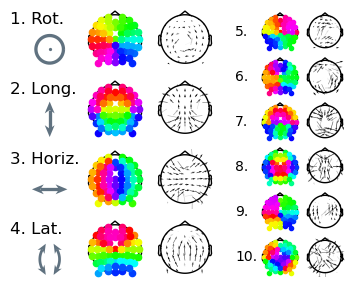

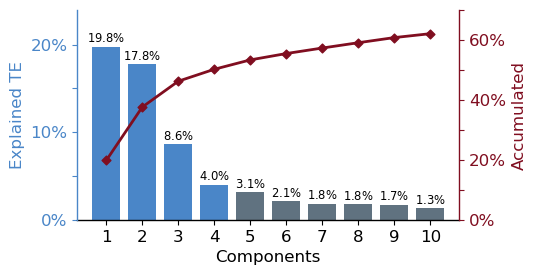

In [141]:
# %% Draw WOCCA components

# Draw phasemaps
fx, fy = 3.35, 2.7
fig = plt.figure(figsize = [fx, fy])
for i in range(4):
    fig.text(0, (0.7 * (3 - i) + 0.5) / fy, "{:}. {:}".format(i + 1, comp_labels[i]), ha = "left", va = "center", size = "large")
    ax = plt.axes([0.75 / fx, 0.7 * (3 - i) / fy, 0.6 / fx, 0.6 / fy])
    vis.disp_phasemap(info, ws[i], markersize = 9)
    ax = plt.axes([1.45 / fx, 0.7 * (3 - i) / fy, 0.6 / fx, 0.6 / fy])
    vis.disp_quiver_map(info, ws[i], show_r2 = True, sensors = False, scale = 60, width = 0.01)
    ax = plt.axes([0.2 / fx, 0.7 * (3 - i) / fy, (1 / 2.54) / fx, (1 / 2.54) / fy])
    vis.no_axes(ax)
    draw_icon(i)
for i in range(4, 10):
    fig.text(2.25 / fx, (0.45 * (9 - i) + 0.225) / fy, "{:}.".format(i + 1), ha = "left", va = "center", size = "medium")
    ax = plt.axes([2.5 / fx, (0.45 * (9 - i) + 0.025) / fy, 0.4 / fx, 0.4 / fy])
    vis.disp_phasemap(info, ws[i], markersize = 6)
    ax = plt.axes([2.95 / fx, (0.45 * (9 - i) + 0.025) / fy, 0.4 / fx, 0.4 / fy])
    vis.disp_quiver_map(info, ws[i], show_r2 = True, sensors = False, scale = 40, width = 0.015)
fig.savefig(fig_path + "wocca_core_comps.svg", format = "svg")

# Draw scree plot

wocca_scores = scores[ : 10] / total_energy_core

fig, ax, ax2 = vis.draw_scree_plot(wocca_scores, dpi = 100, text = True, xps = [0.8, 0.15, 0.28, 0.08, 0.8], yps = [0.3, 0.2, 2.1, 0.1], \
                                   xlabel = "Components", classes = np.array([0] * 4 + [1] * 6), class_colors = [scree_bar_wocca_color, default_color], \
                                   yaxis_color = scree_bar_wocca_color, acc_color = scree_accumulated_color)
ax.axis(ymax = 0.24)
ax.set_yticks(np.arange(5) * 0.05)
ax.set_yticklabels([r"0%", "", r"10%", "", r"20%"])
ax2.axis(ymax = 0.7)
ax2.set_yticks(np.arange(8) * 0.1)
ax2.set_yticklabels([r"0%", "", r"20%", "", r"40%", "", r"60%", ""])

fig.savefig(fig_path + "wocca_core_scree.svg", format = "svg")

In [7]:
# %% Load TRT dataset WOCCA components

import ds3_trt as ds3
with open("../wocca_project_pickles/ds3_trt_wocca.pickle", mode = "rb") as FIn:
    ws_trt = pickle.load(FIn)[1]

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 61
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 61
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 61
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 61
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 61
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 61
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 61
Could not find a adjacency matrix 

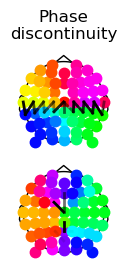

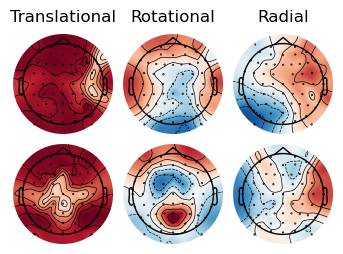

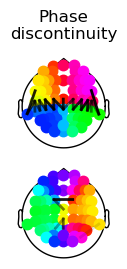

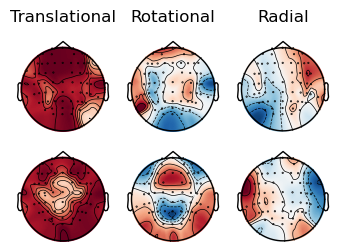

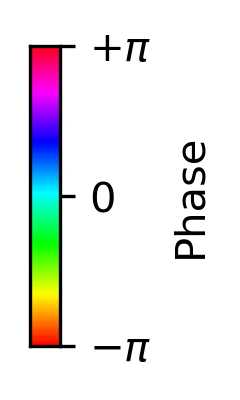

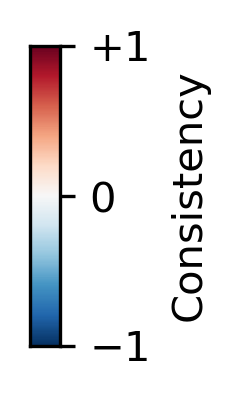

In [8]:
# %% Draw Comp.5 and 6 spatial distributions

tmp_fi = []
tmp_di = []
for tmp_w, tmp_info, tmp_prefix in [[ws, info, "leipzig"], [ws_trt, ds3.info, "trt"]]:
    field_ind_fun = grad.fit_global_indices(tmp_info)
    field_inds = np.zeros([n_comps, 3, len(tmp_info.ch_names)])
    for i in range(n_comps):
        field_inds[i] = field_ind_fun(tmp_w[i])[1 : ]
    tmp_fi.append(np.abs(field_inds).max(axis = 1).min(axis = -1))
    
    disc_inds = np.zeros([n_comps])
    for i in range(n_comps):
        tmp_da = grad.detect_phase_discontinuity(tmp_info)(tmp_w[i])[2]
        disc_inds[i] = ((tmp_da / np.pi * 2 - 1) ** 2).sum()
    tmp_di.append(disc_inds)
        
    fx, fy = 1.2, 2.7
    fig = plt.figure(figsize = [fx, fy])
    for i in range(2):
        ax = plt.axes([0.1 / fx, (1.2 - 1.1 * i) / fy, 1 / fx, 1 / fy])
        vis.disp_phasemap(tmp_info, tmp_w[i + 4], markersize = 15)
        tmp_d, tmp_dp, tmp_da = grad.detect_phase_discontinuity(tmp_info)(tmp_w[i + 4], dist_thres = 0.1)
        for j in range(len(tmp_dp)):
            plt.plot(tmp_dp[j, : , 0], tmp_dp[j, : , 1], lw = 2, c = "#000000", alpha = tmp_da[j] / np.pi * 2 - 1)
    fig.text(0.5, 2.3 / fy, "Phase\ndiscontinuity", ha = "center", va = "bottom", size = "large")
    fig.savefig(fig_supp_path + tmp_prefix + "_comp5_6_phase.svg", format = "svg")
    
    fx, fy = 3.4, 2.7
    fig = plt.figure(figsize = [fx, fy])
    for i in range(2):
        for j in range(3):
            ax = plt.axes([(0.1 + 1.1 * j) / fx, (1.2 - 1.1 * i) / fy, 1 / fx, 1 / fy])
            vis.disp_topomap(tmp_info, field_inds[i + 4, j], vmin = -1, vmax = 1, cmap = "RdBu_r", colorbar = False)
    for i in range(3):
        fig.text((0.6 + 1.1 * i) / fx, 2.3 / fy, ["Translational", "Rotational", "Radial"][i], ha = "center", va = "bottom", size = "large")
    fig.savefig(fig_supp_path + tmp_prefix + "_comp5_6_indices.svg", format = "svg")

    # fx, fy = 3.3, 2.3
    # fig = plt.figure(figsize = [fx, fy])
    # ax = plt.axes([0.7 / fx, 0.5 / fy, 2.5 / fx, 1.5 / fy])
    

# Colorbars
fig = vis.colorbar("hsv", fs = [0.7, 1.2], bs = [0.1, 1], ticks = np.array([0, 0.5, 1]), vmin = 0, vmax = 1, \
                   tick_labels = [r"$-\pi$", r"$0$", r"$+\pi$"], caption = "Phase")
fig.savefig(fig_supp_path + "leipzig_comp5_6_phase_colorbar.svg", format = "svg")
fig = vis.colorbar("RdBu_r", fs = [0.7, 1.2], bs = [0.1, 1], ticks = np.array([-1, 0, 1]), vmin = -1, vmax = 1, \
                   tick_labels = [r"$-1$", r"$0$", r"$+1$"], caption = "Consistency")
fig.savefig(fig_supp_path + "leipzig_comp5_6_indices_colorbar.svg", format = "svg")

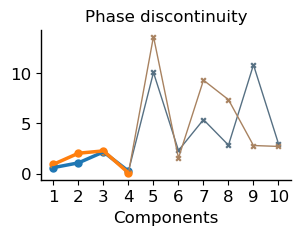

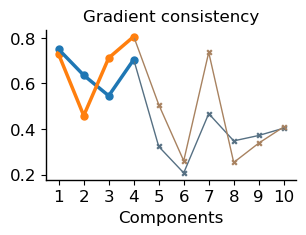

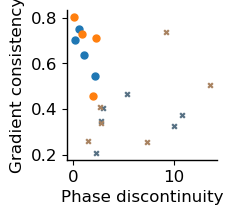

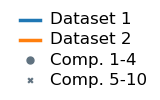

In [18]:
# %% Selection
fx, fy = 3.3, 2.3
for tmp_i, tmp_str, tmp_fn in [[tmp_di, "Phase discontinuity", "phase"], [tmp_fi, "Gradient consistency", "gradient"]]:
    fig = plt.figure(figsize = [fx, fy])
    ax = plt.axes([0.7 / fx, 0.5 / fy, 2.5 / fx, 1.5 / fy])
    plt.axis(xmin = -0.5, xmax = 9.5)
    for j in range(2):
        plt.plot(np.arange(3, 10), tmp_i[j][3 : ], lw = 1, c = vis.sat_mod(vis.colors[j], -0.7))
        plt.scatter(np.arange(4, 10), tmp_i[j][4 : ], s = 20, marker = "X", lw = 0, c = vis.sat_mod(vis.colors[j], -0.7))
        plt.plot(np.arange(4), tmp_i[j][ : 4], lw = 2.5, c = vis.colors[j])
        plt.scatter(np.arange(4), tmp_i[j][ : 4], s = 25, c = vis.colors[j])
    vis.lower_left(ax)
    plt.title(tmp_str)
    ax.set_xticks(np.arange(10))
    ax.set_xticklabels([str(i + 1) for i in range(10)])
    ax.tick_params(labelsize = "large")
    plt.xlabel("Components", size = "large")
    fig.savefig(fig_supp_path + "choosing_criterion_plots_" + tmp_fn + ".svg", format = "svg")

# Scatter
fx, fy = 2.3, 2.3
fig = plt.figure(figsize = [fx, fy])
ax = plt.axes([0.7 / fx, 0.5 / fy, 1.5 / fx, 1.5 / fy])
for j in range(2):
    plt.scatter(tmp_di[j][ : 4], tmp_fi[j][ : 4], c = vis.colors[j], s = 25)
    plt.scatter(tmp_di[j][4 : ], tmp_fi[j][4 : ], s = 20, marker = "X", lw = 0, c = vis.sat_mod(vis.colors[j], -0.7))
vis.lower_left(ax)
ax.tick_params(labelsize = "large")
plt.xlabel("Phase discontinuity", size = "large")
plt.ylabel("Gradient consistency", size = "large")
fig.savefig(fig_supp_path + "choosing_criterion_plane.svg", format = "svg")

# Standalone legends
fx, fy = 1.4, 0.8
fig = plt.figure(figsize = [fx, fy])
ax = plt.axes([0, 0, 1, 1])
plt.axis([0, fx, 0, fy])
vis.no_axes(ax)
plt.plot([0.1, 0.3], [0.7, 0.7], lw = 2.5, c = vis.colors[0])
plt.plot([0.1, 0.3], [0.5, 0.5], lw = 2.5, c = vis.colors[1])
plt.text(0.4, 0.7, "Dataset 1", ha = "left", va = "center", size = "large")
plt.text(0.4, 0.5, "Dataset 2", ha = "left", va = "center", size = "large")
plt.scatter(0.2, 0.3, s = 25, c = default_color)
plt.scatter(0.2, 0.1, s = 20, marker = "X", lw = 0, c = default_color)
plt.text(0.4, 0.3, "Comp. 1-4", ha = "left", va = "center", size = "large")
plt.text(0.4, 0.1, "Comp. 5-10", ha = "left", va = "center", size = "large")
fig.savefig(fig_supp_path + "choosing_criterion_plots_legend.svg", format = "svg")

In [6]:
# %% Statistics for EC/EO

# Calculate session and subject means
asym = average_per_subject(projs)
energy = average_per_subject(projs ** 2)

# Testing EC/EO comparisons
eceo_test_asym = np.zeros([n_comp_save, 3])
eceo_test_energy = np.zeros_like(eceo_test_asym)
for i in range(n_comp_save):
    eceo_test_asym[i, : 2] = stats.ttest_rel(asym[ : , 0, i], asym[ : , 1, i])
    eceo_test_asym[i, 2] = core.effect_size_rel(asym[ : , 0, i], asym[ : , 1, i])
    eceo_test_energy[i, : 2] = stats.ttest_rel(energy[ : , 0, i], energy[ : , 1, i])
    eceo_test_energy[i, 2] = core.effect_size_rel(energy[ : , 0, i], energy[ : , 1, i])

# Testing asymmetry against zero
zero_test_asym = np.zeros([n_states, n_comp_save, 3])
for i in range(n_states):
    for j in range(n_comp_save):
        zero_test_asym[i, j, : 2] = stats.ttest_1samp(asym[ : , i, j], 0)
        zero_test_asym[i, j, 2] = asym[ : , i, j].mean() / asym[ : , i, j].std(ddof = 1)

print(eceo_test_energy, eceo_test_asym, zero_test_asym, sep = "\n")

[[ 1.69505431e+00  9.16060241e-02  1.18969489e-01]
 [ 1.15261760e+01  5.97776675e-24  8.08978960e-01]
 [-8.76816981e+00  7.52158496e-16 -6.15404876e-01]
 [ 1.87150757e+00  6.27203578e-02  1.31354081e-01]
 [ 4.10972122e+00  5.75711003e-05  2.88445883e-01]]
[[ 4.46095007e-01  6.56006417e-01  3.13097315e-02]
 [-3.07000347e+00  2.43477923e-03 -2.15472002e-01]
 [ 4.85211453e+00  2.43815356e-06  3.40551678e-01]
 [-6.14644641e+00  4.15797222e-09 -4.31395967e-01]
 [-3.64149922e-02  9.70987421e-01 -2.55583141e-03]]
[[[-6.39002531e-01  5.23545195e-01 -4.48491854e-02]
  [-7.13733380e+00  1.67526831e-11 -5.00942627e-01]
  [ 2.66119288e+00  8.41256226e-03  1.86779124e-01]
  [-8.41864092e+00  6.98204911e-15 -5.90872757e-01]
  [ 3.04075092e+00  2.67256253e-03  2.13418876e-01]]

 [[-1.78178982e+00  7.62858151e-02 -1.25057129e-01]
  [-8.31732878e+00  1.32176769e-14 -5.83762039e-01]
  [-2.86501643e+00  4.61078785e-03 -2.01084733e-01]
  [-2.88035150e+00  4.40084943e-03 -2.02161044e-01]
  [ 6.26646564e+00

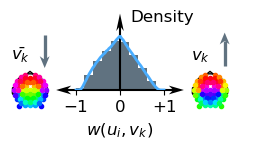

In [167]:
# %% Draw projection diagram

# Calculate a sample histogram
hs, xs = np.histogram(projs[ : , 1], bins = 10, range = [-1, 1])
hs1, xs1 = np.histogram(projs[ : , 1], bins = 100, range = [-1, 1])

# Draw
fx, fy = 2.3, 1.4
fig = plt.figure(figsize = [fx, fy])
ax = plt.axes([0.55 / fx, 0.55 / fy, 1.2 / fx, 0.7 / fy])
tmp_scale = 2.7 / 1.2
plt.axis([-1.35, 1.35, 0, tmp_scale * 0.6])
plt.plot([-1.2, 1.2], [0, 0], lw = 1.5, c = "#000000", clip_on = False)
icons.draw_arrow_head([1.2, 0], [tmp_scale * 0.15, 0], "#000000", tmp_scale * 0.075, 0.3)
icons.draw_arrow_head([-1.2, 0], [-tmp_scale * 0.15, 0], "#000000", tmp_scale * 0.075, 0.3)
plt.plot([0, 0], [0, tmp_scale * 0.55], lw = 1.5, c =  "#000000", clip_on = False)
icons.draw_arrow_head([0, tmp_scale * 0.55], [0, tmp_scale * 0.15], "#000000", tmp_scale * 0.075, 0.3)
ax.set_frame_on(False)
ax.set_xticks([-1, 0, 1])
ax.set_xticklabels([vis.minus_sign + "1", "0", "+1"])
ax.set_yticks([])
ax.tick_params(labelsize = "large")

plt.bar(xs[ : -1] + (xs[1] - xs[0]) / 2, hs / 800000, xs[1] - xs[0], color = default_color)
plt.plot(xs1[ : -1] + (xs1[1] - xs1[0]) / 2, hs1 / 80000, lw = 2, c = state_colors[1])
fig.text(1.25 / fx, 1.2 / fy, "Density", ha = "left", va = "bottom", size = "large")
fig.text(1.15 / fx, 0.05 / fy, "$w(u_i,v_k)$", ha = "center", va = "bottom", size = "large")

ax = plt.axes([0.05 / fx, 0.35 / fy, 0.4 / fx, 0.4 / fy])
vis.disp_phasemap(info, ws[1], markersize = 6)
fig.text(0.15 / fx, 0.8 / fy, r"$\bar{v_k}$", ha = "center", va = "bottom", size = "large")
ax = plt.axes([0.2 / fx, 0.75 / fy, (1 / 2.54) / fx, (1 / 2.54) / fy])
plt.axis([-0.5, 0.5, -0.5, 0.5])
icons.longitudinal_bw(default_color, scale = 1 / 2.54)
vis.no_axes(ax)

ax = plt.axes([1.85 / fx, 0.35 / fy, 0.4 / fx, 0.4 / fy])
vis.disp_phasemap(info, np.conj(ws[1]), markersize = 6)
fig.text(1.95 / fx, 0.8 / fy, "$v_k$", ha = "center", va = "bottom", size = "large")
ax = plt.axes([2 / fx, 0.75 / fy, (1 / 2.54) / fx, (1 / 2.54) / fy])
plt.axis([-0.5, 0.5, -0.5, 0.5])
icons.longitudinal_fw(default_color, scale = 1 / 2.54)
vis.no_axes(ax)

fig.savefig(fig_path + "projection_histogram_sample.svg", format = "svg")

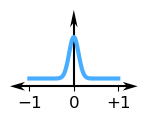

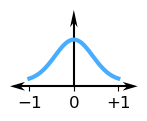

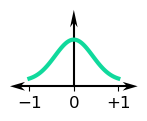

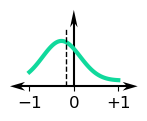

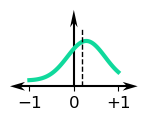

In [166]:
# %% Draw statistics diagram

# Function for drawing axis
def draw_projection_axis():
    fx, fy = 1.3, 1.1
    fig = plt.figure(figsize = [fx, fy])
    ax = plt.axes([0.05 / fx, 0.3 / fy, 1.2 / fx, 0.7 / fy])
    tmp_scale = 2.7 / 1.2
    plt.axis([-1.35, 1.35, 0, tmp_scale * 0.6])
    plt.plot([-1.2, 1.2], [0, 0], lw = 1.5, c = "#000000", clip_on = False)
    icons.draw_arrow_head([1.2, 0], [tmp_scale * 0.15, 0], "#000000", tmp_scale * 0.075, 0.3)
    icons.draw_arrow_head([-1.2, 0], [-tmp_scale * 0.15, 0], "#000000", tmp_scale * 0.075, 0.3)
    plt.plot([0, 0], [0, tmp_scale * 0.55], lw = 1.5, c =  "#000000", clip_on = False)
    icons.draw_arrow_head([0, tmp_scale * 0.55], [0, tmp_scale * 0.15], "#000000", tmp_scale * 0.075, 0.3)
    ax.set_frame_on(False)
    ax.set_xticks([-1, 0, 1])
    ax.set_xticklabels([vis.minus_sign + "1", "0", "+1"])
    ax.set_yticks([])
    ax.tick_params(labelsize = "large")

    return fig, ax

xs = np.linspace(-1, 1, 101, True)

# Draw for traveling energy
ys_thin = np.exp(-(xs ** 2) / (0.15 ** 2)) * 0.8 + 0.15
ys_fat = np.exp(-(xs ** 2) / (0.6 ** 2)) * 0.8 + 0.1

fig, ax = draw_projection_axis()
ax.plot(xs, ys_thin, lw = 3, color = compare_colors[0][1])
fig.savefig(fig_path + "projection_energy_sample_thin.svg", format = "svg")

fig, ax = draw_projection_axis()
ax.plot(xs, ys_fat, lw = 3, color = compare_colors[0][1])
fig.savefig(fig_path + "projection_energy_sample_fat.svg", format = "svg")

# Draw for asymmetry
ys_left = (np.exp(-((xs + 0.3) ** 2) / (0.6 ** 2)) * 0.8 + 0.1) * (1 + 0.1 * xs)
ys_right = (np.exp(-((xs - 0.3) ** 2) / (0.6 ** 2)) * 0.8 + 0.1) * (1 - 0.1 * xs)

fig, ax = draw_projection_axis()
ax.plot(xs, ys_fat, lw = 3, color = compare_colors[1][1])
fig.savefig(fig_path + "projection_asym_sample_center.svg", format = "svg")

fig, ax = draw_projection_axis()
ax.plot(xs, ys_left, lw = 3, color = compare_colors[1][1])
ax.plot([(xs * ys_left).sum() / ys_left.sum()] * 2, [0, 1.1], lw = 1, c = "#000000", ls = "--")
fig.savefig(fig_path + "projection_asym_sample_left.svg", format = "svg")

fig, ax = draw_projection_axis()
ax.plot(xs, ys_right, lw = 3, color = compare_colors[1][1])
ax.plot([(xs * ys_right).sum() / ys_right.sum()] * 2, [0, 1.1], lw = 1, c = "#000000", ls = "--")
fig.savefig(fig_path + "projection_asym_sample_right.svg", format = "svg")

In [ ]:
# %% Statistics for age and EC/EO


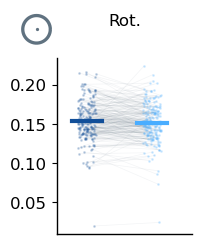

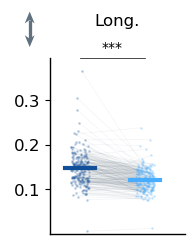

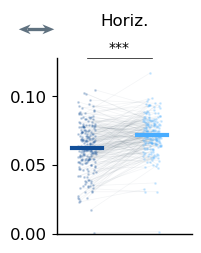

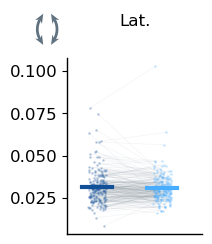

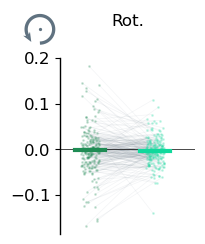

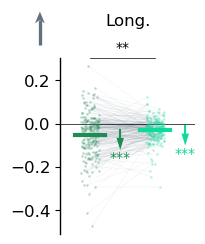

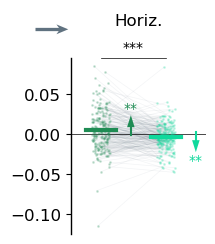

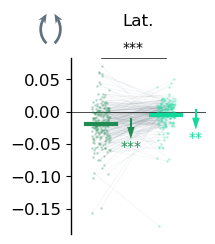

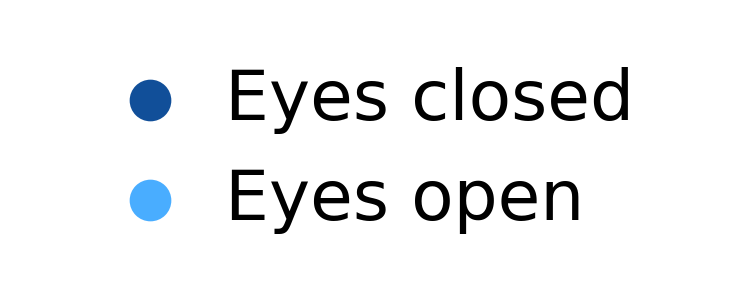

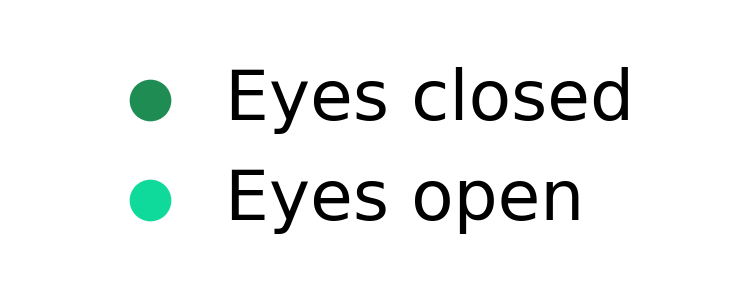

In [163]:
# %% Draw EC/EO comparisons

# Energy
yticks = [[0.05, 0.1, 0.15, 0.2], \
          [0.1, 0.2, 0.3], \
          [0, 0.05, 0.1], \
          [0.025, 0.05, 0.075, 0.1]]
for i in range(4):
    fig, ax, column_lims = draw_eceo_energy_bars(i)
    ax.set_yticks(yticks[i])
    fig.savefig(fig_path + "eceo_energy_comp{:}.svg".format(i + 1), format = "svg")

# Asymmetry
yticks = [[-0.1, 0, 0.1, 0.2], \
          [-0.4, -0.2, 0, 0.2], \
          [-0.1, -0.05, 0, 0.05], \
          [-0.15, -0.1, -0.05, 0, 0.05]]
for i in range(4):
    fig, ax, column_lims = draw_eceo_asym_bars(i)
    ax.set_yticks(yticks[i])
    fig.savefig(fig_path + "eceo_asym_comp{:}.svg".format(i + 1), format = "svg")

# EC/EO legends
fig = plt.figure(figsize = [1.3, 0.4], dpi = 500)
ax = plt.axes([0, 0, 1, 1])
vis.no_axes(ax)
plt.axis([0, 1.3, 0, 0.4])
plt.scatter([0.2], [0.3], s = 25, c = compare_colors[0][0])
plt.text(0.35, 0.3, state_names_full[0], ha = "left", va = "center", size = "medium")
plt.scatter([0.2], [0.1], s = 25, c = compare_colors[0][1])
plt.text(0.35, 0.1, state_names_full[1], ha = "left", va = "center", size = "medium")
fig.savefig(fig_path + "eceo_energy_scatter_legends.svg", format = "svg")

fig = plt.figure(figsize = [1.3, 0.4], dpi = 500)
ax = plt.axes([0, 0, 1, 1])
vis.no_axes(ax)
plt.axis([0, 1.3, 0, 0.4])
plt.scatter([0.2], [0.3], s = 25, c = compare_colors[1][0])
plt.text(0.35, 0.3, state_names_full[0], ha = "left", va = "center", size = "medium")
plt.scatter([0.2], [0.1], s = 25, c = compare_colors[1][1])
plt.text(0.35, 0.1, state_names_full[1], ha = "left", va = "center", size = "medium")
fig.savefig(fig_path + "eceo_asym_scatter_legends.svg", format = "svg")